<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/multimodal-recsys/03_cross_modal.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/03_cross_modal.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Cross-Modal Utilization (Part 3)

Multimodal recommender systems are commonly catalogued based on the type of auxiliary data (modality) they leverage, such as preference data plus user-network (social), user/item texts
(textual), or item images (visual) respectively. One consequence of this siloization along modality lines is the tendency for virtual walls to arise between modalities. For instance, a model ostensibly designed for images would experiment with only the image modality, and compare to other models also purportedly designed
for images. In turn, a text-based model would be
compared to another text-based model, similarly
with item graph. However, most multimodal recommendation algorithms are innately machine learning models that fit the preference data, aided by the auxiliary data as features
in some form. While the raw representations of modalities
may differ, the eventual representations used in the learning
process may have commonalities in form (textual product
description may be represented as term vectors, related
items as a vector of adjacent graph neighbors, etc.). Indeed,
if we peel off the layer of pre-processing steps specific to
a modality, we find that, for most models, the underlying
representation can accommodate other modalities. It is this aspect that we explore in this notebook, i.e., using a model for a modality different from the
one it was originally designed for [1]. 

## 1. Setup

In [1]:
!pip install --quiet cornac==1.14.1

In [2]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import torch

%tensorflow_version 1.x
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.datasets import amazon_clothing
from cornac.eval_methods import RatioSplit
from cornac.data import GraphModality, TextModality, ImageModality

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()

TensorFlow 1.x selected.
System version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Cornac version: 1.14.1
Tensorflow version: 1.15.2


## 2. Using CDL, VBPR and MCF with the Text Modality


We consider the Amazon Clothing dataset consisting of user-item ratings and item content information (e.g., text, visual features, relations). For the purpose of the following experiment, assume that we are interested in item textual descriptions only. To leverage this modalidy we consider three different models, namely CDL [2], VBPR [3], and MCF [4]. While the former was originally and experimented with text auxiliary data, VBPR and MCF have been investigated for integrating visual and graph information respectively. The following code illustrates how Cornac [5] enables to use VBPR and MCF with text auxiliary data.

In [3]:
# Load and split the Amazon clothing dataset
ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE,
)

# obtain global mapping of item ID to synchronize across modalities 
item_id_map = ratio_split.global_iid_map

# build item text modality using the item text corpus
VOCAB_SIZE = 5000
text_modality = TextModality(corpus=docs, ids=item_ids, max_vocab=VOCAB_SIZE)
text_modality.build(id_map=item_id_map)

# here we use term-frequency matrix from item text as features, other choices available
item_ids = list(item_id_map.keys())
tf_mat = text_modality.count_matrix.A  # term-frequency matrix
tf_mat = tf_mat[:len(item_ids)]  # remove unknown items during data splitting

# build image modality with the term-frequency matrix as features 
image_modality = ImageModality(features=tf_mat, ids=item_ids)
image_modality.build(id_map=item_id_map)

# build graph modality with the term-frequency matrix as features.
# Under the hood this will construct a k-nearest neighbor graph of items, encoding textual similarities among them.
graph_modality = GraphModality.from_feature(features=tf_mat, ids=item_ids, k=5, similarity="cosine")
graph_modality.build(id_map=item_id_map)


# provide all built modalities for access by models during the experiment
ratio_split.add_modalities(item_text=text_modality, 
                           item_image=image_modality, 
                           item_graph=graph_modality)


cdl = cornac.models.CDL(k=50, autoencoder_structure=[200], vocab_size=VOCAB_SIZE, 
                        act_fn='tanh', max_iter=50, seed=SEED, verbose=VERBOSE)

vbpr = cornac.models.VBPR(k=10, k2=40, n_epochs=50, use_gpu=USE_GPU, seed=SEED, verbose=VERBOSE)

mcf = cornac.models.MCF(k=50, max_iter=50, seed=SEED, verbose=VERBOSE)


recall = cornac.metrics.Recall(k=50)
ndcg = cornac.metrics.NDCG(k=50)


text_exp = cornac.Experiment(eval_method=ratio_split,  
                             models=[cdl, vbpr, mcf],
                             metrics=[recall, ndcg])
text_exp.run()

Building KNN graph:   0%|          | 0/3321 [00:00<?, ?it/s]

Optimization finished!

TEST:
...
     | NDCG@50 | Recall@50 | Train (s) | Test (s)
---- + ------- + --------- + --------- + --------
CDL  |  0.0538 |    0.1372 |   59.1471 |   1.7099
VBPR |  0.0598 |    0.1854 |   47.6192 |   1.5046
MCF  |  0.0592 |    0.1483 |    3.6911 |   1.7586



## Question 1

Without looking at section 3 and 4, can you write a Cornac code to use the above three models with the image-modility and the Graph-modality?

## 3. Using CDL, VBPR and MCF with the Image Modality

In [4]:
ratings = amazon_clothing.load_feedback()
features, item_ids = amazon_clothing.load_visual_feature()


# construct item modalities using the image features
image_modality = ImageModality(features=features, ids=item_ids) 
text_modality = TextModality(features=features, ids=item_ids)
graph_modality = GraphModality.from_feature(features=features, ids=item_ids, k=5, similarity="cosine")


# provide all modalities into evaluation method to synchronize the building process
# as we don't have to build them separately for this case (available features)
ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE,
    item_text=text_modality,
    item_image=image_modality,
    item_graph=graph_modality,
)


cdl = cornac.models.CDL(k=50, autoencoder_structure=[200], vocab_size=text_modality.feature_dim,
                        act_fn='tanh', max_iter=50, seed=SEED, verbose=VERBOSE)

vbpr = cornac.models.VBPR(k=10, k2=40, n_epochs=50, use_gpu=False, seed=SEED, verbose=VERBOSE)

mcf = cornac.models.MCF(k=50, max_iter=50, seed=SEED, verbose=VERBOSE)


recall = cornac.metrics.Recall(k=50)
ndcg = cornac.metrics.NDCG(k=50)


image_exp = cornac.Experiment(eval_method=ratio_split, 
                              models=[cdl, vbpr, mcf],
                              metrics=[recall, ndcg])
image_exp.run()

Building KNN graph:   0%|          | 0/3393 [00:00<?, ?it/s]

Optimization finished!

TEST:
...
     | NDCG@50 | Recall@50 | Train (s) | Test (s)
---- + ------- + --------- + --------- + --------
CDL  |  0.0642 |    0.1720 |   50.7828 |   1.7099
VBPR |  0.0468 |    0.1291 |   60.7699 |   1.5051
MCF  |  0.0570 |    0.1550 |    3.5292 |   1.7978



## 4. Using CDL, VBPR and MCF with Graph Modality

In [5]:
ratings = amazon_clothing.load_feedback()
contexts = amazon_clothing.load_graph()


ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE,
)

# obtain global mapping of item ID to synchronize across modalities 
item_id_map = ratio_split.global_iid_map  
item_ids = list(item_id_map.keys())

# build item graph modality using the item contexts
graph_modality = GraphModality(data=contexts).build(id_map=item_id_map)
adj_mat = graph_modality.matrix.A  # item graph adjacency matrix

# build text and image modalities with the adjacency matrix as features 
text_modality = TextModality(features=adj_mat, ids=item_ids).build(id_map=item_id_map)
image_modality = ImageModality(features=adj_mat, ids=item_ids).build(id_map=item_id_map)


# provide all built modalities for access by models during the experiment
ratio_split.add_modalities(item_text=text_modality,
                           item_image=image_modality,
                           item_graph=graph_modality)


cdl = cornac.models.CDL(k=50, autoencoder_structure=[200], vocab_size=text_modality.feature_dim,
                        act_fn='tanh', max_iter=50, seed=SEED, verbose=VERBOSE)

vbpr = cornac.models.VBPR(k=10, k2=40, n_epochs=50, use_gpu=USE_GPU, seed=SEED, verbose=VERBOSE)

mcf = cornac.models.MCF(k=50, max_iter=50, seed=SEED, verbose=VERBOSE)


recall = cornac.metrics.Recall(k=50)
ndcg = cornac.metrics.NDCG(k=50)


graph_exp = cornac.Experiment(eval_method=ratio_split, 
                              models=[cdl, vbpr, mcf],
                              metrics=[recall, ndcg])
graph_exp.run()

Optimization finished!

TEST:
...
     | NDCG@50 | Recall@50 | Train (s) | Test (s)
---- + ------- + --------- + --------- + --------
CDL  |  0.0783 |    0.2074 |   45.7099 |   1.6808
VBPR |  0.0870 |    0.2290 |   45.6348 |   1.5313
MCF  |  0.0927 |    0.2334 |    2.5589 |   1.8568



## 5. Results: Recall and NDCG Bar Plots

To make it convenient to analyze the results of the experiments from sections 2—4, the following code generates the Recall and NDCG bar plots across models and modalities.    

In [6]:
res_df = defaultdict(list)
for text_res, image_res, graph_res in zip(text_exp.result, image_exp.result, graph_exp.result):
  assert text_res.model_name == image_res.model_name == graph_res.model_name
  res_df["Model"].extend([text_res.model_name] * 3)
  res_df["Modality"].extend(["Text", "Image", "Graph"])
  res_df[recall.name].extend([text_res.metric_avg_results[recall.name],
                              image_res.metric_avg_results[recall.name],
                              graph_res.metric_avg_results[recall.name]])
  res_df[ndcg.name].extend([text_res.metric_avg_results[ndcg.name],
                            image_res.metric_avg_results[ndcg.name],
                            graph_res.metric_avg_results[ndcg.name]])
res_df = pd.DataFrame(res_df)

### Recall

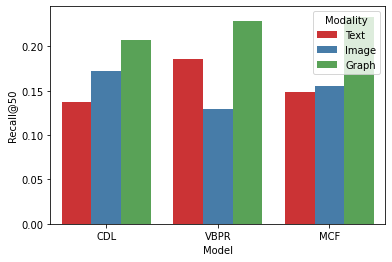

In [7]:
sns.barplot(x="Model", y=recall.name, hue="Modality", palette="Set1", data=res_df);

### NDCG

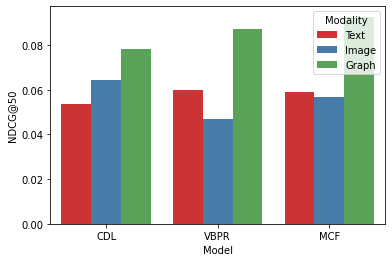

In [8]:
sns.barplot(x="Model", y=ndcg.name, hue="Modality", palette="Set1", data=res_df);

## Question 2

Based on the above results, what can you infer regarding cross-modality utilization? 

## References

1.   Truong, Q. T., Salah, A., Tran, T. B., Guo, J., & Lauw, H. W. (2021). Exploring Cross-Modality Utilization in Recommender Systems. IEEE Internet Computing.
2.   Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).
3.   He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.
4.   Park, C., Kim, D., Oh, J., & Yu, H. (2017, April). Do" Also-Viewed" Products Help User Rating Prediction?. In Proceedings of the 26th International Conference on World Wide Web (pp. 1113-1122).
5.   Salah, A., Truong, Q. T., & Lauw, H. W. (2020). Cornac: A Comparative Framework for Multimodal Recommender Systems. J. Mach. Learn. Res., 21, 95-1. https://cornac.preferred.ai

